<a href="https://colab.research.google.com/github/jakelem/CIS700HW01/blob/master/my_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text adventure game

This Python notebook builds a simple text advenutre game inspired by the [Adventuron Classroom](https://adventuron.io/classroom/) design by Chris Ainsley of Adventuron Software Limited.

The main components are:
1. __The parser__, which interprets the player's commands.
2. __The game__, which represents the world (a collection of __locations__ and __items__), and describes what the player sees.
3. __The data__, which you input to create your own unique game.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [0]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at, inventory={}, introduction=""):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    self.score = 0
    # inventory is the set of objects that the player has collected/
    self.inventory = inventory
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True
    self.initial_scene = introduction
    self.states = {}

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_initial(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    if len(self.initial_scene) > 0:
      print(self.initial_scene)

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            function, arguments, preconditions = item.commands[cmd]
            if check_preconditions(preconditions, self, print_failure_reasons=False):
              print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    if item.never_taken:
        self.score += 5
        print("current score: ", self.score)
        item.never_taken = False
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [0]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description, end_game=False):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # True if entering this location should end the game
    self.end_game = end_game
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [0]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_does_not_have_item":
      item = preconditions[check]
      if item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s is blocking your way" % item.name)
    if check == "item_is_obstacle":
      item = preconditions[check]
      if item.obstacle:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s is blocking your way" % item.name)
    if check == "item_flagged":
      item = preconditions[check]
      if not item.flagged:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s is flagged" % item.name)
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    if check == "game_state_true":
      state = preconditions[check]
      if state not in game.states or not game.states[state]:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % state)

    # todo - add other types of preconditions
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [0]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None,
               gettable=True,
               end_game=False,
               obstacle=False,
               never_taken=True):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    # Indicates whether a player can get the object and put it in their inventory.
    self.gettable = gettable
    # True if entering this location should end the game.
    self.end_game = end_game
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.never_taken = never_taken
    self.flagged = False
    # Indicates whether the object is blocking the player or not
    self.obstacle = obstacle
    self.commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game      


## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [0]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.

    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]
          if not self.game.curr_location.has_been_visited:
            self.game.score += 2
            print("current score: ", self.game.score)

            self.game.curr_location.has_been_visited = True
          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.end_game:
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.end_game

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: ", end = '')
      print(*descriptions, sep = ", ",)
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.gettable:
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          
          print(item.take_text)
          end_game = item.end_game
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None

## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [0]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def add_points(game, *args):
  (points) = args[0]
  game.score += points
  print("current score: ", game.score)

def perform_conditional_action(game, *args):
  (condition, true_actions, false_actions) = args[0]
  
  if check_preconditions(condition, game):
    function, arguments = true_actions
    return function(game,arguments)
  else:
    function, arguments = false_actions
    return function(game,arguments)

def flag_item(game, *args):
  (item) = args[0]
  item.flagged = True
  return False

def set_state(game, *args):
  (state, value, action_description) = args[0]
  game.states[state] = value
  print(action_description)

  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  else:
    print(action_description)
  return False


def destroy_item_in_location(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, location, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in location.items:
    location.remove_item(item)
    print(action_description)
  else:
    print(already_done_description)
  return False

def create_item_in_location(game, *args):
  (item, location, action_description) = args[0]
  location.add_item(item.name, item)
  print(action_description)


def create_item(game, *args):
  """Adds an item to the current location in the game."""
  (item, action_description) = args[0]
  game.curr_location.add_item(item.name, item)
  print(action_description)
  
  return False

def set_item_obstacle(game, *args):
  """Changes the obstacle status of an object"""
  (item, action_description, obstacle) = args[0]
  item.obstacle = obstacle
  print(action_description)
  return False

def perform_multiple_actions(game, *args):
  actions = args[0]
  end_game = False
  for function, arguments in actions:
    end_game = end_game or function(game,arguments)
  return end_game

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print(end_message)
  return True

## Game Data

Here's where you can define the locations and items in your game.  To get you started, I defined a super-simple fishing game, which contains the first 3 locations of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  

You can play through the whole game with the following commands:
1. take pole
2. go out
3. south 
4. catch fish with pole
5. eat fish

In [0]:
def build_game():
  # Locations
  room = Location("Monarch's Room", "You are standing in your bedroom, where you've lived since childhood.")
  garden = Location("Private Garden", """You are standing in the beautiful garden outside your room.
  To the east is your private library. To the west is the kitchen. To the south is the swamp.""")
  library = Location("Library", """You are in a massive library that only the highest royalty is privy to.
  There are several strange books on the table out front.""")
  kitchen = Location("Royal Kitchen", "You are in the royal kitchen. The servants are asleep tonight.")
  swamp = Location("Swamp", """You are in a dark swamp. You hear the sounds of frogs croaking.
  Oh, how you envy the simple life of a frog, living out its days in a tiny pool!
  There is a mysterious, dark house here that you have never noticed before.""")
  witch_house = Location("Witch's House", """You are inside a mysterious house. 
  There are pillows and bottles everywhere.
  The walls are lined with mysterious potions.
  There is a mysterious, withered woman dressed in purple robes.
  Behind her is a set of stairs leading down.""")

  ritual_space = Location("Ritual Space", """The witch's room for incantations. The floor
  is lined with runes forming a strange pattern. In the center of the room is a 
  massive altar. The top of the altar is empty, but there seems to be a spot where a book might fit.""")

  # Connections
  room.add_connection("south", garden)
  garden.add_connection("east", library)
  garden.add_connection("west", kitchen)
  garden.add_connection("south", swamp)
  swamp.add_connection("in", witch_house)
  witch_house.add_connection("down", ritual_space)

  # Items that you can pick up
  pills = Item("pills", "a bottle of sleeping pills", "SLEEPING PILLS.", start_at=room)
  nuggets = Item("nuggets", "some chicken nuggets", "CHICKEN NUGGETS.", start_at=kitchen)
  frog_book = Item("green book", "a green book", "TRANSMOGRIFICATION FOR DUMMIES.", start_at=library)
  red_book = Item("red book", "a red book", "HOW TO SUMMON DEMONS.", start_at=library)
  blue_book = Item("blue book", "a blue book", "HOW TO VANQUISH YOUR ENEMIES.", start_at=library)

  sleep_nuggets = Item("sleeping nuggets", "a tub of sleeping nuggets", "SLEEPING NUGGETS.")
  potion = Item("potion", "a magic potion", "A POTION.")

  # Sceneary (not things that you can pick up)
  pond = Item("pond", "a small pond", "THERE ARE MANY FROGS ALL AROUND.", start_at=swamp, gettable=False)  
  witch = Item("witch", "a witch", "THE WITCH LOOKS ANCIENT.", start_at=witch_house, gettable=False)
  sleeping_witch = Item("sleeping witch", "sleeping witch", "THE WITCH IS FAST ASLEEP.", gettable=False)
  altar = Item("altar", "an altar", "A MASSIVE ALTAR.", start_at=ritual_space, gettable=False)


  # Add special functions to your items
  frog_book.add_action("read green book",  
                    describe_something, 
                   ("The title is 'TRANSMOGRIFICATION FOR DUMMIES.'"))

  red_book.add_action("read red book",  
                    describe_something, 
                   ("The title is 'HOW TO SUMMON DEMONS.'"))

  blue_book.add_action("read blue book",  
                    describe_something, 
                   ("The title is 'HOW TO VANQUISH YOUR ENEMIES.'"))
  
  nuggets.add_action("mix nuggets with pills",  
                    perform_multiple_actions, 
                   [(add_points, (10)),
                    (destroy_item, (pills,"You crush up the pills and sprinkle them over the nuggets.")),
                    (destroy_item, (nuggets,"You now, for whatever reason, have a box of chicken nuggets laced with sleeping pills.")),
                    (add_item_to_inventory, (sleep_nuggets, "You put the box of sleeping nuggets in your bag.", ""))], 
                   preconditions={"inventory_contains":pills})
  
  witch.add_action("give witch sleeping pills", describe_something, 
                   ("""'Are you dense?' The witch says. 'I have the wisdom
                   of a million millenia on every plane of existence. 
                   I know these are sleeping pills."""), 
                   preconditions={"inventory_contains":pills})

  

  witch.add_action("give witch sleeping nuggets", perform_multiple_actions, 
                   [(add_points, (10)),
                    (destroy_item, (sleep_nuggets,"You give the sleeping nuggets to the witch.")),
                    (destroy_item, (witch,"'I love chicken nuggets!' She exclaims, heartily munching down on several at once.")),
                    (create_item, (sleeping_witch,
                """'Hmm...' she mutters. 'I'm feeling a little tingly though.'
                    A few seconds later she slumps down and begins to snore."""))
                    ], 
                   preconditions={"inventory_contains":sleep_nuggets})
  
  witch.add_action("give witch chicken nuggets", end_game, 
                   ("""'I love chicken nuggets!' the witch exclaims. 
                   But as she begins to bite down on them, a frown forms on her face.
                   'These nuggets are stale!' she declares. 'I have never been so disappointed in
                   my entire immortal life! I shall curse you!'
                   
                   As a punishment, the witch transforms you into a chicken. She throws
                   you outside, and her house vanishes into thin air. You cluck helplessly through the night,
                   unable to find your way back to your quarters. 
                   
                   The next day, the chefs find you in the swamp and assume you have 
                   escaped from the coop. They slaughter you and serve you 
                   to your family for breakfast. THE END"""), 
                   preconditions={"inventory_contains":nuggets})
  
  witch.add_action("talk to witch", describe_something, 
                   ("""The woman cackles maniacally. 'I am the immortal witch!' she says.
                   Every night I travel to a different pocket of space and time in my spectral house, 
                   and tonight I have decided to land here. 
                   
                   I am currently on a food tour of the astral plane and
                   am sampling the cuisine of each dimension I visit. If you have any 
                   suggestions please bring them to me.'"""))
  
  potion.add_action("drink potion", perform_multiple_actions,
                    [(add_points, (10)),
                     (set_state, ("is_frog", True, "The potion turns you into a frog."))])
  
  pills.add_action("eat pills", end_game,
                    """You take the pills and fall asleep. The next day, as always, you continue your training.

                    The days and years pass. Eventually you become the ruler, but you are perpetually unhappy,
                    always wondering how you would feel if you had the chance of the quiet life you always wanted.
                    Nothing magical happens for the rest of your life and you die filled with regret. THE END""")


  nuggets.add_action("eat nuggets", end_game,
                    """You eat the nuggets and develop a bad case of food poisoning, which confines
                    you to your bed the rest of the night. 
                    
                    The next day, as always, you continue your training.

                    The days and years pass. Eventually you become the ruler, but you are perpetually unhappy,
                    always wondering how you would feel if you had the chance of the quiet life you always wanted.
                    Nothing magical happens for the rest of your life and you die filled with regret. THE END""")


  pond.add_action("swim in pond", end_game, 
                  ("You live out the rest of your days joyfully as a frog in the pond. YOU WIN!"), 
                  preconditions={"game_state_true":"is_frog"})
  
  altar.add_action("place green book on altar", perform_multiple_actions,
                    [(add_points, (10)),
                     (set_state, ("is_frog", True, """The green book begins to shine, its pages
                     flipping on their own. A deep, mysterious sound emanates from the ground. Soon
                     the pages of the book are too blinding to look at and you shut your eyes. 
                     The sound crescendos to a deafening croak. Then it all goes silent.
                     
                     As you open your eyes, you realize that the altar is now towering over you. You can barely
                     even see over the side of the books on the floor. You look down and
                     realize that your hands have been replaced by webbed green fingers.
                     You call out, but all that you hear is a tiny croak. You are a
                     frog.
                     
                     You rejoice. This was your dream. Now all you need to do is get to the pond."""))],
                   preconditions={"inventory_contains":frog_book})

  altar.add_action("place red book on altar", end_game,
                   ("""The red book immediately disintegrates into liquid darkness, 
  which spills down the altar into the floor. A fissure then
  explodes beneath you, and tongues of fire lash out. 
  A horde of shrieking red vultures comes climbing from it.
  Soon an entire army of undead birds has emerged from the abyss. They tear you apart. 
  In a matter of hours, the entire world has been engulfed in flames and darkness.
  THE END."""), 
  preconditions={"inventory_contains":red_book})

  altar.add_action("place blue book on altar", describe_something,
                   """You put the blue book on the altar, but nothing happens. Upon further inspection,
                   you realize the book is actually a children's chapter book with
                   the title sleeve replaced. You shrug and put the book back in your bag.""",
                   preconditions={"inventory_contains":blue_book})

  #add blocks to locations
  witch_house.add_block("down", """The witch steps in your way. 'You are forbidden from going downstairs.'""", {"location_does_not_have_item": witch})

  introduction = """
  You are first in line for the throne of a long royal family. 
  You have been educated at the best global universities and have recently returned 
  home to continue your royal training.

  It is midnight. You are pacing around the room, wide awake, thinking about how you never 
  asked for any of this. Truthfully, all you want is a quiet life away from all the 
  pressure and pageantry of the crown. You wish to abdicate, to hand the throne
  over to your much more ambitious younger sister, but your parents refuse
  to hear it. 

  If you could find some way to simply run away and live out your days in the swamp, 
  you would do it in a heartbeat.
  """
  return Game(room, introduction = introduction)



# Play the game
This small snippet of code is what you need to run the game.  Behold! The magestic prompt! 

In [0]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe_initial()
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      print("Final Score: %d " % game.score)

      return

game_loop()
print('THE GAME HAS ENDED.')


  You are first in line for the throne of a long royal family. 
  You have been educated at the best global universities and have recently returned 
  home to continue your royal training.

  It is midnight. You are pacing around the room, wide awake, thinking about how you never 
  asked for any of this. Truthfully, all you want is a quiet life away from all the 
  pressure and pageantry of the crown. You wish to abdicate, to hand the throne
  over to your much more ambitious younger sister, but your parents refuse
  to hear it. 

  If you could find some way to simply run away and live out your days in the swamp, 
  you would do it in a heartbeat.
  
You are standing in your bedroom, where you've lived since childhood.
Exits: South
You see: 
a bottle of sleeping pills
	 eat pills
>take pills
current score:  5
You take the pills.
>go south
current score:  7
You are standing in the beautiful garden outside your room.
  To the east is your private library. To the west is the kitchen. T

# Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

The witch is blocking your way


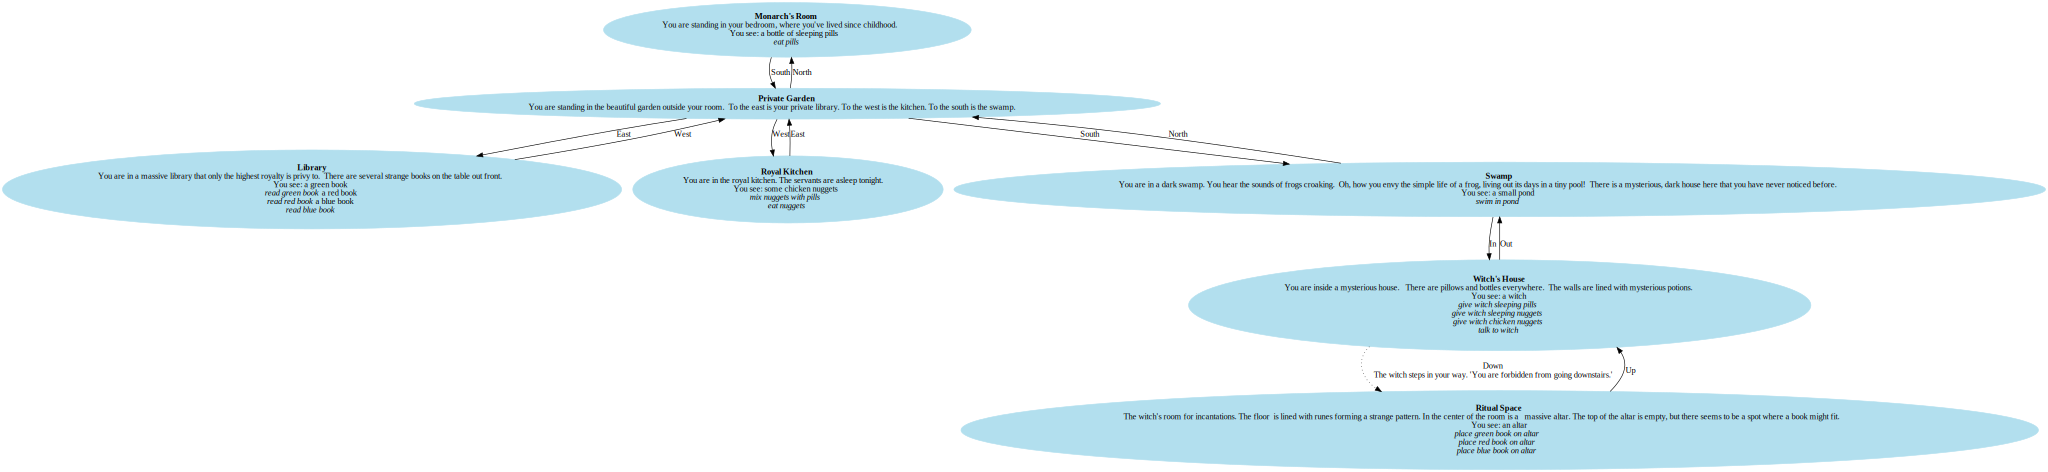

In [0]:
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
#save_to_drive(graph)
graph
